In [1]:
from torch_geometric.datasets import Planetoid
import networkx as nx
import random
import numpy as np
from tqdm import tqdm


# Cargar el dataset Cora
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Convertir a NetworkX de forma robusta
G = nx.Graph()
edge_index = data.edge_index.numpy()

# Asegurar que todos los nodos sean enteros
edges = [(int(u), int(v)) for u, v in zip(edge_index[0], edge_index[1])]
G.add_edges_from(edges)

print(f"Grafo Cora: |V|={G.number_of_nodes()}  |E|={G.number_of_edges()}")



Grafo Cora: |V|=2708  |E|=5278


In [2]:
def alias_setup(probs):
    """
    Convert a probability list into alias tables (J, q) for O(1) sampling.
    returns: (J, q) both length K
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int32)

    # Worklists
    smaller, larger = [], []
    for idx, p in enumerate(probs):
        q[idx] = K * p
        (smaller if q[idx] < 1.0 else larger).append(idx)

    # Populate J, q
    while smaller and larger:
        s = smaller.pop()
        l = larger.pop()
        J[s] = l
        q[l] = q[l] - (1.0 - q[s])
        (smaller if q[l] < 1.0 else larger).append(l)

    return J, q

def alias_draw(J, q):
    """
    Draw a single sample from alias tables.
    """
    K = len(J)
    kk = int(np.floor(np.random.rand() * K))
    return kk if np.random.rand() < q[kk] else J[kk]


In [3]:
class Node2VecWalker:
    def __init__(self, graph, p=1.0, q=1.0, directed=False):
        self.G = graph
        self.p = p
        self.q = q
        self.directed = directed
        self._preprocess_transition_probs()

    # ---------- public ----------
    def simulate_walks(self, num_walks, walk_len, verbose=True):
        walks = []
        nodes = list(self.G.nodes())
        for _ in range(num_walks):
            random.shuffle(nodes)
            for node in tqdm(nodes, disable=not verbose):
                walks.append(self._walk(walk_len, start=node))
        return walks

    # ---------- internal ----------
    def _walk(self, length, start):
        walk = [start]
        while len(walk) < length:
            curr = walk[-1]
            neighbors = sorted(self.G.neighbors(curr))
            if len(neighbors) == 0:
                break

            if len(walk) == 1:
                # first step: simple weighted choice
                next_node = neighbors[alias_draw(*self.alias_nodes[curr])]
            else:
                prev = walk[-2]
                edge_key = (prev, curr) if self.directed else (prev, curr) \
                           if (prev, curr) in self.alias_edges else (curr, prev)
                next_node = neighbors[alias_draw(*self.alias_edges[edge_key])]
            walk.append(next_node)
        return [str(n) for n in walk]          # gensim expects str tokens

    # Pre-compute alias tables -----------------------------------------------
    def _get_edge_alias(self, src, dst):
        """
        Transition probs conditioned on (src=prev, dst=curr),
        equations (2) and (3) of the paper
        """
        probs = []
        for dst_nbr in sorted(self.G.neighbors(dst)):
            weight = self.G[dst][dst_nbr].get('weight', 1.0)
            if dst_nbr == src:            # distance = 0
                bias = 1 / self.p
            elif self.G.has_edge(dst_nbr, src):
                bias = 1                  # distance = 1
            else:
                bias = 1 / self.q         # distance = 2
            probs.append(weight * bias)
        norm = sum(probs)
        probs = [p / norm for p in probs]
        return alias_setup(probs)

    def _preprocess_transition_probs(self):
        # Alias for 1-hop neighbors (first step)
        self.alias_nodes = {}
        for node in self.G.nodes():
            probs = [self.G[node][nbr].get('weight', 1.0)
                     for nbr in sorted(self.G.neighbors(node))]
            norm = sum(probs)
            probs = [p / norm for p in probs]
            self.alias_nodes[node] = alias_setup(probs)

        # Alias for conditional edges (second-order)
        self.alias_edges = {}
        for edge in self.G.edges():
            self.alias_edges[edge] = self._get_edge_alias(edge[0], edge[1])
            if not self.directed:
                self.alias_edges[(edge[1], edge[0])] = self._get_edge_alias(edge[1], edge[0])


In [4]:
# Hyper-parameters (paper defaults are p=q=1; tweak to explore)
WALK_LENGTH  = 10
NUM_WALKS    = 100
P, Q         = 1, 0.5          # BFS ↔ DFS balance

G = nx.relabel_nodes(G, lambda x: str(x))  # Fuerza a que todos los nodos sean str


walker = Node2VecWalker(G, p=P, q=Q, directed=False)
walks  = walker.simulate_walks(NUM_WALKS, WALK_LENGTH)
print(f"Generated {len(walks)} walks – e.g. {walks[0][:10]} …")

100%|██████████| 2708/2708 [00:00<00:00, 61596.65it/s]

Generated 270800 walks – e.g. ['2545', '10', '476', '10', '2545', '10', '2545', '10', '476', '306'] …


In [5]:
from torch_spikgram import train_skipgram
import torch


nodes = list(G.nodes())
emb_dict = train_skipgram(
    walks,
    node_list=nodes,
    emb_dim=64,
    window=10,
    neg_samples=5,
    epochs=1,
    lr=0.025,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


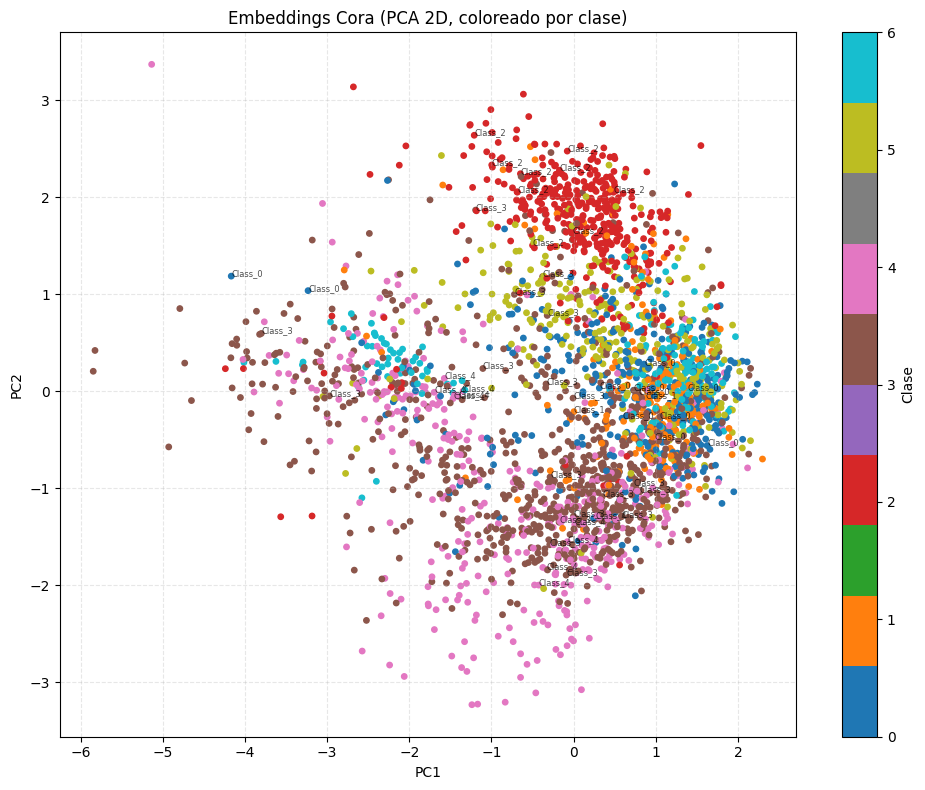

In [6]:
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Diccionario de clases
cora_classes = dataset[0].y.unique().numpy()
label_map = {i: f"Class_{i}" for i in cora_classes}

# Nodos válidos que están en emb_dict
valid_nodes = [n for n in G.nodes() if str(n) in emb_dict]

# Embeddings y etiquetas
vectors = np.array([emb_dict[str(n)] for n in valid_nodes])
labels = [data.y[int(n)].item() for n in valid_nodes]  # <-- CAST aquí

# PCA
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(vectors)

# Graficar
plt.figure(figsize=(10, 8))
scatter = plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='tab10', s=15)

# Etiquetas opcionales
for i, node in enumerate(valid_nodes[:50]):
    class_id = data.y[int(node)].item()
    plt.text(proj[i, 0], proj[i, 1], label_map[class_id], fontsize=6, alpha=0.7)

plt.title("Embeddings Cora (PCA 2D, coloreado por clase)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.colorbar(scatter, ticks=range(len(cora_classes)), label='Clase')
plt.show()


In [7]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def most_similar(target_node, topk=5):
    target_node = str(target_node)  # por si las claves del dict son strings
    if target_node not in emb_dict:
        raise ValueError(f"Nodo {target_node} no encontrado en emb_dict.")
        
    target_vec = emb_dict[target_node].reshape(1, -1)
    all_nodes = list(G.nodes())
    
    all_vecs = np.array([emb_dict[str(n)] for n in all_nodes if str(n) in emb_dict])
    valid_nodes = [n for n in all_nodes if str(n) in emb_dict]
    
    sims = cosine_similarity(target_vec, all_vecs).flatten()
    top_indices = sims.argsort()[::-1][1:topk+1]  # excluir el propio nodo
    return [(valid_nodes[i], sims[i]) for i in top_indices]


print("Vecinos más similares a nodo 0:")
for node, sim in most_similar(0):
    print(f"Nodo {node:<4} → similitud: {sim:.3f}")



Vecinos más similares a nodo 0:
Nodo 1701 → similitud: 0.680
Nodo 633  → similitud: 0.679
Nodo 1993 → similitud: 0.665
Nodo 1166 → similitud: 0.656
Nodo 1874 → similitud: 0.650


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

# Paso 1: obtener nodos con embedding y su clase
valid_nodes = [n for n in G.nodes() if str(n) in emb_dict]
X = np.array([emb_dict[str(n)] for n in valid_nodes])
y = np.array([data.y[int(n)].item() for n in valid_nodes])

# Paso 2: dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Paso 3: entrenar clasificador (por ejemplo, Logistic Regression)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Paso 4: predecir y calcular métricas
y_pred = clf.predict(X_test)

f1_macro = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")


Accuracy: 0.7319
F1 Macro: 0.7193


Wikipedia


In [14]:
from torch_geometric.datasets import WikipediaNetwork
import networkx as nx
import numpy as np

# Cargar el dataset Wikipedia (puede ser "chameleon", "squirrel", "crocodile")
dataset = WikipediaNetwork(root='/tmp/Wikipedia', name='chameleon')
data = dataset[0]

# Convertir a NetworkX
G = nx.Graph()
edge_index = data.edge_index.numpy()

edges = [(int(u), int(v)) for u, v in zip(edge_index[0], edge_index[1])]
G.add_edges_from(edges)

print(f"Grafo Wikipedia (chameleon): |V|={G.number_of_nodes()}  |E|={G.number_of_edges()}")


Grafo Wikipedia (chameleon): |V|=2277  |E|=31421


In [15]:
# Hyper-parameters (paper defaults are p=q=1; tweak to explore)
WALK_LENGTH  = 10
NUM_WALKS    = 100
P, Q         = 1, 0.5          # BFS ↔ DFS balance

G = nx.relabel_nodes(G, lambda x: str(x))  # Fuerza a que todos los nodos sean str


walker = Node2VecWalker(G, p=P, q=Q, directed=False)
walks  = walker.simulate_walks(NUM_WALKS, WALK_LENGTH)
print(f"Generated {len(walks)} walks – e.g. {walks[0][:10]} …")

100%|██████████| 2277/2277 [00:00<00:00, 22508.51it/s]

Generated 227700 walks – e.g. ['195', '1384', '2208', '500', '1462', '151', '2263', '876', '117', '2031'] …


In [17]:
nodes = list(G.nodes())
emb_dict = train_skipgram(
    walks,
    node_list=nodes,
    emb_dim=64,
    window=10,
    neg_samples=5,
    epochs=1,
    lr=0.025,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


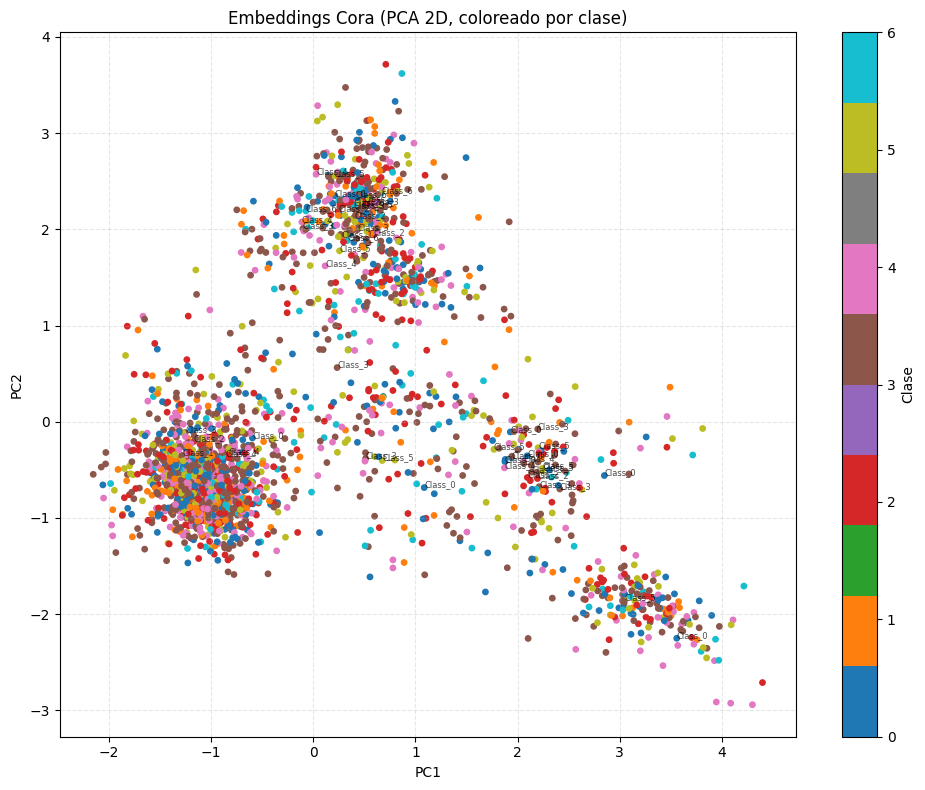

In [18]:
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Diccionario de clases
cora_classes = dataset[0].y.unique().numpy()
label_map = {i: f"Class_{i}" for i in cora_classes}

# Nodos válidos que están en emb_dict
valid_nodes = [n for n in G.nodes() if str(n) in emb_dict]

# Embeddings y etiquetas
vectors = np.array([emb_dict[str(n)] for n in valid_nodes])
labels = [data.y[int(n)].item() for n in valid_nodes]  # <-- CAST aquí

# PCA
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(vectors)

# Graficar
plt.figure(figsize=(10, 8))
scatter = plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='tab10', s=15)

# Etiquetas opcionales
for i, node in enumerate(valid_nodes[:50]):
    class_id = data.y[int(node)].item()
    plt.text(proj[i, 0], proj[i, 1], label_map[class_id], fontsize=6, alpha=0.7)

plt.title("Embeddings Cora (PCA 2D, coloreado por clase)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.colorbar(scatter, ticks=range(len(cora_classes)), label='Clase')
plt.show()


In [20]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def most_similar(target_node, topk=5):
    target_node = str(target_node)  # por si las claves del dict son strings
    if target_node not in emb_dict:
        raise ValueError(f"Nodo {target_node} no encontrado en emb_dict.")
        
    target_vec = emb_dict[target_node].reshape(1, -1)
    all_nodes = list(G.nodes())
    
    all_vecs = np.array([emb_dict[str(n)] for n in all_nodes if str(n) in emb_dict])
    valid_nodes = [n for n in all_nodes if str(n) in emb_dict]
    
    sims = cosine_similarity(target_vec, all_vecs).flatten()
    top_indices = sims.argsort()[::-1][1:topk+1]  # excluir el propio nodo
    return [(valid_nodes[i], sims[i]) for i in top_indices]


print("Vecinos más similares a nodo 0:")
for node, sim in most_similar(0):
    print(f"Nodo {node:<4} → similitud: {sim:.3f}")



Vecinos más similares a nodo 0:
Nodo 1161 → similitud: 0.712
Nodo 1044 → similitud: 0.690
Nodo 1611 → similitud: 0.689
Nodo 2130 → similitud: 0.688
Nodo 2149 → similitud: 0.675


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

# Paso 1: obtener nodos con embedding y su clase
valid_nodes = [n for n in G.nodes() if str(n) in emb_dict]
X = np.array([emb_dict[str(n)] for n in valid_nodes])
y = np.array([data.y[int(n)].item() for n in valid_nodes])

# Paso 2: dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Paso 3: entrenar clasificador (por ejemplo, Logistic Regression)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Paso 4: predecir y calcular métricas
y_pred = clf.predict(X_test)

f1_macro = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")


Accuracy: 0.1769
F1 Macro: 0.1222


BlogCatalog


In [23]:
from torch_geometric.datasets import AttributedGraphDataset

# Descargar manualmente desde: http://leitang.net/code/graph_embedding.zip
dataset = AttributedGraphDataset(root='/tmp/BlogCatalog', name='BlogCatalog')
data = dataset[0]

# Convertir a NetworkX
import networkx as nx

G = nx.Graph()
edge_index = data.edge_index.numpy()
edges = [(int(u), int(v)) for u, v in zip(edge_index[0], edge_index[1])]
G.add_edges_from(edges)

print(f"Grafo BlogCatalog: |V|={G.number_of_nodes()}  |E|={G.number_of_edges()}")


Grafo BlogCatalog: |V|=5196  |E|=171743


In [24]:
# Hyper-parameters (paper defaults are p=q=1; tweak to explore)
WALK_LENGTH  = 10
NUM_WALKS    = 100
P, Q         = 1, 0.5          # BFS ↔ DFS balance

G = nx.relabel_nodes(G, lambda x: str(x))  # Fuerza a que todos los nodos sean str


walker = Node2VecWalker(G, p=P, q=Q, directed=False)
walks  = walker.simulate_walks(NUM_WALKS, WALK_LENGTH)
print(f"Generated {len(walks)} walks – e.g. {walks[0][:10]} …")

100%|██████████| 5196/5196 [00:00<00:00, 12717.52it/s]

Generated 519600 walks – e.g. ['787', '2129', '1887', '3589', '1937', '3589', '3145', '1679', '1478', '1586'] …


In [25]:
from torch_spikgram import train_skipgram
import torch


nodes = list(G.nodes())
emb_dict = train_skipgram(
    walks,
    node_list=nodes,
    emb_dim=64,
    window=10,
    neg_samples=5,
    epochs=1,
    lr=0.025,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

# Paso 1: obtener nodos con embedding y su clase
valid_nodes = [n for n in G.nodes() if str(n) in emb_dict]
X = np.array([emb_dict[str(n)] for n in valid_nodes])
y = np.array([data.y[int(n)].item() for n in valid_nodes])

# Paso 2: dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Paso 3: entrenar clasificador (por ejemplo, Logistic Regression)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Paso 4: predecir y calcular métricas
y_pred = clf.predict(X_test)

f1_macro = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")


Accuracy: 0.4650
F1 Macro: 0.4587


PPI


In [ ]:
from torch_geometric.datasets import PPI

# Este dataset incluye múltiples gráficos (una lista de grafos)
train_dataset = PPI(root='/tmp/PPI', split='train')
val_dataset = PPI(root='/tmp/PPI', split='val')
test_dataset = PPI(root='/tmp/PPI', split='test')

print(f"Train graphs: {len(train_dataset)}")
print(f"Nodes in first graph: {train_dataset[0].num_nodes}")
print(f"Edges in first graph: {train_dataset[0].num_edges}")

# Convertir el primer grafo a NetworkX (por ejemplo)
import networkx as nx

data = train_dataset[0]
G = nx.Graph()
edge_index = data.edge_index.numpy()
edges = [(int(u), int(v)) for u, v in zip(edge_index[0], edge_index[1])]
G.add_edges_from(edges)

print(f"Grafo PPI (1er grafo): |V|={G.number_of_nodes()}  |E|={G.number_of_edges()}")


In [27]:
# Hyper-parameters (paper defaults are p=q=1; tweak to explore)
WALK_LENGTH  = 10
NUM_WALKS    = 100
P, Q         = 1, 0.5          # BFS ↔ DFS balance

G = nx.relabel_nodes(G, lambda x: str(x))  # Fuerza a que todos los nodos sean str


walker = Node2VecWalker(G, p=P, q=Q, directed=False)
walks  = walker.simulate_walks(NUM_WALKS, WALK_LENGTH)
print(f"Generated {len(walks)} walks – e.g. {walks[0][:10]} …")

100%|██████████| 5196/5196 [00:00<00:00, 11566.40it/s]

Generated 519600 walks – e.g. ['959', '995', '2106', '796', '2908', '154', '3032', '2925', '1846', '2138'] …


In [28]:
from torch_spikgram import train_skipgram
import torch


nodes = list(G.nodes())
emb_dict = train_skipgram(
    walks,
    node_list=nodes,
    emb_dim=64,
    window=10,
    neg_samples=5,
    epochs=1,
    lr=0.025,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

# Paso 1: obtener nodos con embedding y su clase
valid_nodes = [n for n in G.nodes() if str(n) in emb_dict]
X = np.array([emb_dict[str(n)] for n in valid_nodes])
y = np.array([data.y[int(n)].item() for n in valid_nodes])

# Paso 2: dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Paso 3: entrenar clasificador (por ejemplo, Logistic Regression)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Paso 4: predecir y calcular métricas
y_pred = clf.predict(X_test)

f1_macro = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")


Accuracy: 0.4727
F1 Macro: 0.4676
